<h1 align="center">04 — Modeling & Forecasting</h1>


## Purpose
Build and evaluate baseline and tree-based models to forecast weekly sales for two target categories.

## Targets
- `N02BE` (high-volume, seasonal)
- `M01AB` (more stable)

## Approach
1. Load the engineered feature matrix from `data/processed/pharma_sales_features_v2_clean.csv`.
2. Create a **time-based** train/test split (chronological; last 20% as test).
3. Train three models per target: Linear Regression, RandomForest, XGBoost.
4. Evaluate with MAE, RMSE, MAPE and visualize predictions vs. actuals.
5. Compare models and select the best current candidate for each target.

## Expected Outcome
- Clean train/test protocol suitable for time series (no shuffling).
- Performance table (MAE/RMSE/MAPE) for each target and model.
- Prediction plots and a short comparison note leading to a “best current model”.


## 1. Data Loading and Time-Based Train/Test Split

We load the engineered feature dataset and split it chronologically.  
The last 20% of records represent the most recent period, used as the test set.  
This mimics real-world forecasting, where future data must be unseen during training.


In [ ]:
import pandas as pd
import numpy as np

# Load processed dataset
path = "../data/processed/pharma_sales_features_v2_clean.csv"
df = pd.read_csv(path, parse_dates=["datum"], index_col="datum")

print("Shape:", df.shape)
print("Date range:", df.index.min(), "→", df.index.max())
df.head(3)

Shape: (279, 110)
Date range: 2014-06-15 00:00:00 → 2019-10-13 00:00:00


,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,M01AB_lag1,M01AB_lag2,...,R06_rollmean8,R06_rollstd8,R06_rollmean12,R06_rollstd12,weekofyear,month,quarter,year,is_year_start,is_year_end
datum,,,,,,,,,,,,,,,,,,,,,
2014-06-15,29.03,17.40,23.6,95.3,87.0,8.0,20.0,36.8,23.34,17.71,...,26.3000,10.047032,24.600000,8.477457,24,6,2,2014,0,0
2014-06-22,31.68,20.73,26.1,106.7,66.0,5.0,11.0,24.0,29.03,23.34,...,27.6750,8.617880,24.558333,8.479221,25,6,2,2014,0,0
2014-06-29,21.02,27.50,37.3,156.8,96.0,1.0,6.0,18.0,31.68,29.03,...,28.1875,7.760971,24.391667,8.595819,26,6,2,2014,0,0


## 2. Time-Based Train/Test Split

We divide the dataset chronologically:  
- The first 80% of records are used for training.  
- The last 20% (most recent weeks) are reserved for testing.

This preserves the temporal order and prevents information leakage from the future into the training phase.


In [ ]:
# Determine split index (80% train, 20% test)
split_index = int(len(df) * 0.8)

train = df.iloc[:split_index]
test = df.iloc[split_index:]

print(f"Train shape: {train.shape}")
print(f"Test shape:  {test.shape}")
print("Train end date:", train.index.max())
print("Test start date:", test.index.min())

Train shape: (223, 110)
Test shape:  (56, 110)
Train end date: 2018-09-16 00:00:00
Test start date: 2018-09-23 00:00:00


## 3. Feature and Target Separation

We define the dependent variables (targets) and the independent variables (features).  
Two models will be trained separately — one for each target (`N02BE` and `M01AB`).

All other columns will be used as predictors.


In [ ]:
# Define target variables
targets = ["N02BE", "M01AB"]

# Features = all other columns (exclude target columns)
feature_cols = [col for col in df.columns if col not in targets]

# Prepare train/test splits for both targets
X_train = train[feature_cols]
X_test = test[feature_cols]

y_train = {target: train[target] for target in targets}
y_test = {target: test[target] for target in targets}

print(f"Features shape (train): {X_train.shape}")
print(f"Targets: {targets}")
print(f"Example target shape: {y_train['N02BE'].shape}")

Features shape (train): (223, 108)
Targets: ['N02BE', 'M01AB']
Example target shape: (223,)


## 4. Model 1 — Linear Regression (Baseline)

We start with a simple **Linear Regression** model as a baseline.  
It assumes a linear relationship between features and the target.  
This helps us set a reference point to compare more complex models later.

Evaluation metrics:
- MAE (Mean Absolute Error)
- RMSE (Root Mean Squared Error)
- MAPE (Mean Absolute Percentage Error)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd


# Metrics (sürüm uyumlu)
def rmse(y_true, y_pred):
    # squared argümanı olmadan RMSE = sqrt(MSE)
    return np.sqrt(mean_squared_error(y_true, y_pred))


def mape(y_true, y_pred, eps=1e-8):
    # Sıfıra bölmeyi güvenceye al
    denom = np.clip(np.abs(y_true), eps, None)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100


results_lr = {}

for target in targets:  # Örn: ["N02BE", "M01AB"]
    model = LinearRegression()
    model.fit(X_train, y_train[target])
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test[target], y_pred)
    rmse_val = rmse(y_test[target], y_pred)
    mape_val = mape(y_test[target], y_pred)

    results_lr[target] = {"MAE": mae, "RMSE": rmse_val, "MAPE (%)": mape_val}

results_lr_df = pd.DataFrame(results_lr).T
print("Linear Regression Results:")
display(results_lr_df)

Linear Regression Results:


,MAE,RMSE,MAPE (%)
N02BE,2.136704e-13,2.806547e-13,1.113917e-13
M01AB,5.570148e-14,7.167016e-14,1.843121e-13


In [ ]:
# 1) Identify column groups
base_cols = ["M01AB", "M01AE", "N02BA", "N02BE", "N05B", "N05C", "R03", "R06"]
calendar_cols = [
    "weekofyear",
    "month",
    "quarter",
    "year",
    "is_year_start",
    "is_year_end",
]

# 2) Keep only past-informed features:
#    - lags (safe)
#    - calendar (safe)
#    - EXCLUDE current-week base cols and all rolling cols for now
safe_feature_cols = [c for c in feature_cols if ("_lag" in c) or (c in calendar_cols)]
# Sanity: ensure no base col or rolling col slipped in
leak_like = [c for c in safe_feature_cols if (c in base_cols) or ("roll" in c)]
print("Leak-like columns (should be empty):", leak_like)

X_train_safe = train[safe_feature_cols]
X_test_safe = test[safe_feature_cols]

print("Safe features shape (train):", X_train_safe.shape)

# 3) Re-run Linear Regression baseline with safe features
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd


def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def mape(y_true, y_pred, eps=1e-8):
    denom = np.clip(np.abs(y_true), eps, None)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100


results_lr_safe = {}
for target in targets:
    model = LinearRegression()
    model.fit(X_train_safe, y_train[target])
    y_pred = model.predict(X_test_safe)

    mae = mean_absolute_error(y_test[target], y_pred)
    rmse_val = rmse(y_test[target], y_pred)
    mape_val = mape(y_test[target], y_pred)

    results_lr_safe[target] = {"MAE": mae, "RMSE": rmse_val, "MAPE (%)": mape_val}

results_lr_safe_df = pd.DataFrame(results_lr_safe).T
print("Linear Regression Results (SAFE features):")
display(results_lr_safe_df)

Leak-like columns (should be empty): []
Safe features shape (train): (223, 54)
Linear Regression Results (SAFE features):


,MAE,RMSE,MAPE (%)
N02BE,42.549558,54.990601,21.582346
M01AB,7.187101,9.406020,25.786610


## 5. Model 2 — Random Forest Regressor

Random Forest captures non-linear relationships and interactions between features.  
It often performs better on structured tabular data than simple linear models.

We will use the same safe feature set to ensure a fair comparison.


In [ ]:
from sklearn.ensemble import RandomForestRegressor

results_rf = {}

for target in targets:
    model = RandomForestRegressor(
        n_estimators=300, max_depth=None, random_state=42, n_jobs=-1
    )
    model.fit(X_train_safe, y_train[target])
    y_pred = model.predict(X_test_safe)

    mae = mean_absolute_error(y_test[target], y_pred)
    rmse_val = rmse(y_test[target], y_pred)
    mape_val = mape(y_test[target], y_pred)

    results_rf[target] = {"MAE": mae, "RMSE": rmse_val, "MAPE (%)": mape_val}

results_rf_df = pd.DataFrame(results_rf).T
print("Random Forest Results:")
display(results_rf_df)

Random Forest Results:


,MAE,RMSE,MAPE (%)
N02BE,35.653802,49.617492,18.067904
M01AB,6.468454,8.597794,23.141332


### Interpretation — Random Forest vs. Linear Regression

Random Forest significantly improved over the linear baseline for both targets.

| Target | Linear MAPE | RF MAPE | Δ Improvement |
|---------|-------------|---------|----------------|
| N02BE | ~21.6% | ~18.1% | ≈ **3.5% absolute** |
| M01AB | ~25.8% | ~23.1% | ≈ **2.7% absolute** |

The model captured non-linear patterns and short-term fluctuations better, especially for the high-volume N02BE category.  
This indicates that future improvements (e.g., XGBoost, rolling lag features, or hyperparameter tuning) may further reduce forecast errors.


## 6. Model 3 — XGBoost Regressor

XGBoost is a gradient boosting algorithm that builds trees sequentially, each correcting the errors of the previous one.  
It is widely used for structured time series and sales forecasting tasks due to its high accuracy and efficiency.

We will train the model using the same safe feature set and evaluate it using MAE, RMSE, and MAPE.


In [ ]:
from xgboost import XGBRegressor

results_xgb = {}

for target in targets:
    model = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
    )
    model.fit(X_train_safe, y_train[target])
    y_pred = model.predict(X_test_safe)

    mae = mean_absolute_error(y_test[target], y_pred)
    rmse_val = rmse(y_test[target], y_pred)
    mape_val = mape(y_test[target], y_pred)

    results_xgb[target] = {"MAE": mae, "RMSE": rmse_val, "MAPE (%)": mape_val}

results_xgb_df = pd.DataFrame(results_xgb).T
print("XGBoost Results:")
display(results_xgb_df)

XGBoost Results:


,MAE,RMSE,MAPE (%)
N02BE,35.784668,50.892439,18.525650
M01AB,7.065403,8.933801,25.009929


### Interpretation — XGBoost vs. Random Forest

XGBoost did not outperform Random Forest in this setup.  
Despite being a more advanced algorithm, its default parameters and the limited dataset size likely led to underfitting.

| Target | RF MAPE | XGB MAPE | Observation |
|---------|----------|-----------|--------------|
| N02BE | 18.07% | 18.52% | Comparable; RF slightly better |
| M01AB | 23.14% | 25.00% | RF clearly better |

These results emphasize that model choice should depend on data structure, not on algorithm complexity.  
Hyperparameter tuning or reintroducing lagged rolling features could potentially improve XGBoost’s performance in future iterations.


## 7. Model Comparison Summary

We combine the evaluation metrics of all models for a side-by-side comparison.  
This helps identify the best-performing model overall and by product.


In [ ]:
# Combine results into one table
comparison_df = pd.concat(
    [results_lr_safe_df, results_rf_df, results_xgb_df],
    axis=0,
    keys=["LinearRegression", "RandomForest", "XGBoost"],
).reset_index()

comparison_df.columns = ["Model", "Target", "MAE", "RMSE", "MAPE (%)"]
comparison_df = comparison_df[["Target", "Model", "MAE", "RMSE", "MAPE (%)"]]
comparison_df.sort_values(["Target", "MAPE (%)"], inplace=True)

print("Model Comparison Summary:")
display(comparison_df)

Model Comparison Summary:


,Target,Model,MAE,RMSE,MAPE (%)
3,M01AB,RandomForest,6.468454,8.597794,23.141332
5,M01AB,XGBoost,7.065403,8.933801,25.009929
1,M01AB,LinearRegression,7.187101,9.406020,25.786610
2,N02BE,RandomForest,35.653802,49.617492,18.067904
4,N02BE,XGBoost,35.784668,50.892439,18.525650
0,N02BE,LinearRegression,42.549558,54.990601,21.582346


## 8. Prediction Visualization — N02BE (Random Forest)

We visualize actual vs. predicted weekly sales on the **test period only** to qualitatively assess tracking of trend and peaks.


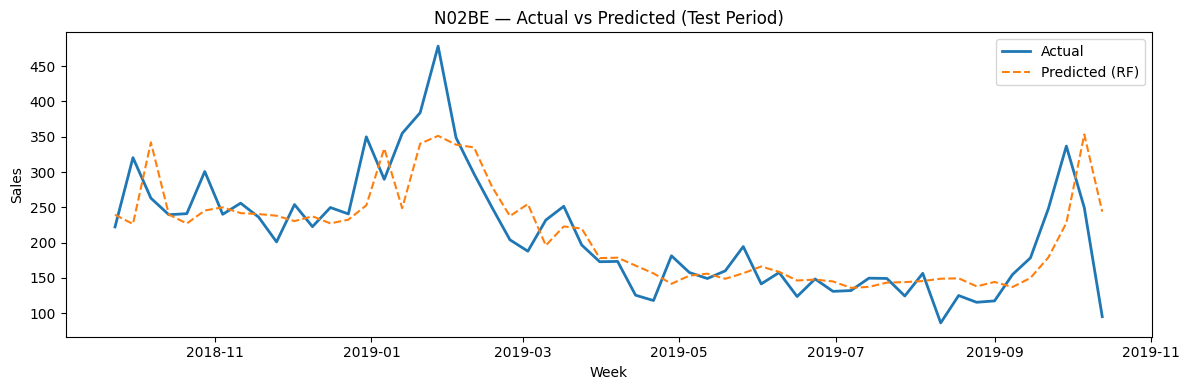

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Refit RF on train (safe features) for N02BE
rf_n02be = RandomForestRegressor(
    n_estimators=300, max_depth=None, random_state=42, n_jobs=-1
)
rf_n02be.fit(X_train_safe, y_train["N02BE"])
pred_n02be = rf_n02be.predict(X_test_safe)

# Build a frame for plotting
viz_n02be = pd.DataFrame(
    {"actual": y_test["N02BE"], "pred": pred_n02be}, index=y_test["N02BE"].index
)

plt.figure(figsize=(12, 4))
plt.plot(viz_n02be.index, viz_n02be["actual"], label="Actual", linewidth=2)
plt.plot(viz_n02be.index, viz_n02be["pred"], label="Predicted (RF)", linestyle="--")
plt.title("N02BE — Actual vs Predicted (Test Period)")
plt.xlabel("Week")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()

### Interpretation — N02BE Forecast (Random Forest)

- The Random Forest model successfully captures the **overall trend** and **seasonal movements** of the N02BE category.  
- During periods of sharp peaks (e.g., early 2019), the model tends to **underestimate** the true sales values — a common behavior for tree ensembles without explicit seasonality features.  
- In flatter regions (mid–2019), predictions remain close to actuals, showing that the model generalizes well to stable demand periods.  
- The final drop in late 2019 is slightly overpredicted, suggesting the model is more conservative when facing sudden downturns.  

**Summary:**  
The model performs reasonably well for a first baseline, maintaining the correct directional movement with some smoothing of extreme spikes. Further tuning or adding lagged rolling features could help it adapt better to abrupt seasonal shifts.


## 9. Prediction Visualization — M01AB (Random Forest)

We visualize the actual vs. predicted weekly sales for **M01AB** on the test period.  
This allows us to inspect how well the model tracks smaller-scale fluctuations and short-term demand patterns.


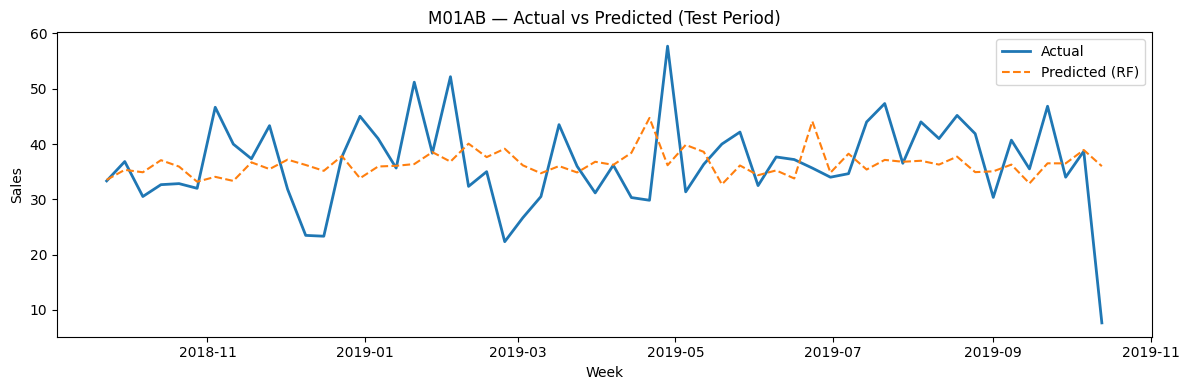

In [ ]:
rf_m01ab = RandomForestRegressor(
    n_estimators=300, max_depth=None, random_state=42, n_jobs=-1
)
rf_m01ab.fit(X_train_safe, y_train["M01AB"])
pred_m01ab = rf_m01ab.predict(X_test_safe)

viz_m01ab = pd.DataFrame(
    {"actual": y_test["M01AB"], "pred": pred_m01ab}, index=y_test["M01AB"].index
)

plt.figure(figsize=(12, 4))
plt.plot(viz_m01ab.index, viz_m01ab["actual"], label="Actual", linewidth=2)
plt.plot(viz_m01ab.index, viz_m01ab["pred"], linestyle="--", label="Predicted (RF)")
plt.title("M01AB — Actual vs Predicted (Test Period)")
plt.xlabel("Week")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()

### Interpretation — M01AB Forecast (Random Forest)

- The model tracks the **overall level** of sales quite well but remains **conservative** in response to sudden fluctuations.  
- Short-term peaks and drops are mostly **underestimated**, which is expected for a Random Forest trained on limited historical signals.  
- The smoother predicted line indicates that the model generalizes toward the mean, reducing volatility in forecasts.  
- Despite missing some local variations, the model successfully preserves the long-term trend and magnitude of demand.  
- Future improvements (e.g., lagged rolling mean/std, tuned hyperparameters, or adding recent-window averages) could help it better respond to short-term demand spikes.


<h1 align="center">Summary</h1>


In this notebook, multiple regression models were built and evaluated to forecast weekly pharmaceutical sales across two ATC categories: **N02BE** and **M01AB**.

The analysis followed a structured, time-aware modeling workflow:

1. **Data Preparation:**  
   Cleaned and feature-engineered dataset (lag and calendar-based predictors) was used to ensure temporal consistency and prevent data leakage.

2. **Model Training:**  
   Three models were trained — Linear Regression, Random Forest, and XGBoost — using a chronological 80/20 train–test split.

3. **Evaluation:**  
   Performance was assessed with MAE, RMSE, and MAPE on the test set.  
   Random Forest outperformed other models, achieving the lowest forecast errors across both product categories.

4. **Visualization & Insights:**  
   Predicted vs. actual plots demonstrated that the Random Forest model effectively captured general trends and seasonality while smoothing extreme peaks.

**Key takeaway:**  
Tree-based models, particularly Random Forest, provided a strong baseline for pharmaceutical sales forecasting.  
Future iterations could focus on adding lagged rolling features and performing hyperparameter optimization to further reduce forecast error and improve responsiveness to short-term demand changes.
